<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/banner_IA.png"  width="1000px" height="200px">

# **Taller 02:  Genetic Algorithms**

## **Outline**

1. [Ejercicio 1.](#eje1)
2. [Ejercicio 2.](#eje2)
3. [Ejercicio 3.](#eje3)
4. [Ejercicio 4.](#eje4)
5. [Ejercicio 5.](#eje5)
6. [Ejercicio 6.](#eje6)



In [ ]:
#@title **Execute this cell**
#@markdown Please include your student id
import sys
import inspect

group_id = "IA1-20252-G1" #@param {type:"string"}
assignment_id = group_id +'.taller_ga'
student_id = "2204002" #@param {type:"string"}
"""
Put your student ID here

Example: student_id =  '2152145'
"""

"\nPut your student ID here\n\nExample: student_id =  '2152145'\n"

In [ ]:
 #@title **Execute this cell**
#@markdown **UTILS**
#@markdown Please dont modify any line in this cell

import os
import json
import requests
from collections import namedtuple


Config = namedtuple('Config', ['server_name'])
config = Config(server_name='https://bivlabgrader.azurewebsites.net/api')


def check_solution_and_evaluate(assignment_id: str, student_func_str: str):

    # Set the endpoint and payload.
    payload = {
        'func_str': student_func_str,
        'assignment_id': assignment_id,
        'student_id': student_id
    }
    endpoint_url = config.server_name + '/CheckAndEvaluateSolution'
    # print(endpoint_url)

    # Make request to server with the data coming from the notebook.
    r = requests.post(endpoint_url, params=payload)
    pprint_json_response(r.json())
    return r


def pprint_json_response(response, indent=0):
    """Pretty print the response."""
    for key, value in response.items():
        print('\t' * indent + str(key.capitalize()))

        # If dictionary, do a recurrent call.
        if isinstance(value, dict):
            pprint_json_response(value, indent + 1)
        else:
            # Enumerate elements if list.
            if isinstance(value, list):
                if len(value) == 1:
                    print('\t' * (indent + 1) + str(value[0]))
                else:
                    for i, e in enumerate(value, start=1):
                        print('\t' * (indent + 1) + f'{i}. {e}')
            else:
                print('\t' * (indent + 1) + str(value))

In [ ]:
#@title **Import libraries**

import matplotlib.pyplot as plt
import numpy as np
np.random.seed(21)

# **Problema: Encontrar la raiz de una función convexa**

Las **funciones convexas** (*un "tazón hacia arriba"*) son esenciales en **inteligencia artificial**. Por ejemplo, si medimos cuanto aprende un método por el error de sus predicciones, podemos hacer métodos para que logren encontrar el valor **CERO ERROR** de esta función. Un ejemplo de estas funciones se ilustra en la siguiente figura:


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/-/raw/master/imgs/funcion_convexa.png">

🚨 **Desafio**

Para una función convexa $f(x) = x²-4$ (ejemplo de este notebook) vamos a generar soluciones aleatorias (números codificados como cadenas binarias) y utilizando **algoritmos genéticos** vamos a tratar de encontrar la solución correcta (valor de x, donde f(x) es cero).

Como soporte de este notebook, te dejamos las siguientes funciones:
- dibujo de la función $f(x) = x²-4$
- función para generar arreglos binarios de longitud fija. La cual es la base para generar nuestras posibles soluciones.
- función que convierte un arreglo binario a un numero decimal.


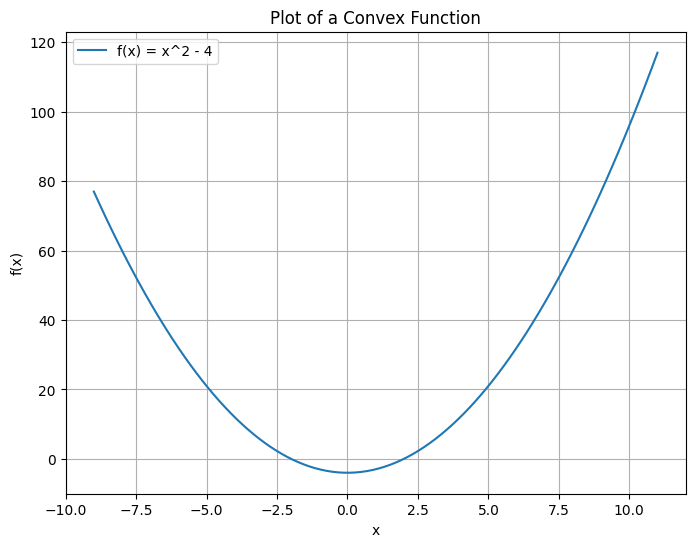

In [ ]:
#@title función $f(x) = x²-4$
import matplotlib.pyplot as plt
import numpy as np

def convex_function(x):
  import numpy as np
#   y = (x-2)**2
  y = (x**2) - 4
  return y

# Generamos el dominio X de la funcion
x_values = np.linspace(-9, 11, 100)

# Calculamos la salida de la funcion para cada uno de los elementos en el dominio
y_values = convex_function(x_values)

# Graficamos
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label='f(x) = x^2 - 4')
plt.title('Plot of a Convex Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#@title Función para generar arreglos binarios de longitud fija
def gen_binary_array_number(num_bits):
  import numpy as np
  return np.random.randint(0,2, size=num_bits)


In [ ]:
#@title Funcion que convierte un arreglo binario a un numero decimal
def gen_decimal_value(binary_array, num_bits, min_val, max_val):
  import numpy as np
  powers_of_2 = 2**np.arange(len(binary_array) - 1, -1, -1)
  int_val = np.dot(binary_array, powers_of_2)
  decimal_value = min_val + int_val * (max_val - min_val) / (2**num_bits - 1)
  #print(int_val, decimal_value)
  return decimal_value

---
# **Ejercicio 1**  <a name="eje1"></a>
---

## **Generacion de poblacion**

En los algoritmos genéticos, ``el primer paso consiste en crear una población inicial de posibles soluciones``. Cada individuo de esta población representa una solución candidata al problema, y suele codificarse como una cadena binaria.

En este caso, cada individuo o posible solución será un arreglo de bits (ceros y unos), cuya longitud está determinada por el número de bits (genes) que usemos para representar posibles valores de ``x``

### **Objetivo**

Implementar una función (``convex_initialize_population``), la cual recibe como parámetros ``n_individuals, num_bits`` generando una población inicial de ``n_individuals`` con la cantidad de bits (``num_bits``) que codifican cada solución.

### **Ejemplo**

Supongamos que se requieren 4 individuos de 5 bits cada uno:

```
Individuos (binarios)       Equivalente en decimal
-------------------------------------------------
[1, 0, 1, 0, 1]   --->          21
[0, 1, 0, 1, 0]   --->          10
[1, 1, 0, 0, 1]   --->          25
[0, 0, 0, 1, 1]   --->           3
```
En este caso cada fila es un candidato de la población inicial.


In [ ]:
#@title **code student**
def convex_initialize_population(n_individuals, num_bits):
    """
    Genera una población inicial de posibles soluciones en forma binaria.

    Parámetros:
      n_individuals: número de individuos (filas en la población)
      num_bits: número de bits (longitud de cada individuo)

    Retorna:
      np.array con shape (n_individuals, num_bits)
    """
    import numpy as np

    # Crear matriz con 0s y 1s de tamaño (n_individuals, num_bits)
    population = np.random.randint(0, 2, size=(n_individuals, num_bits))

    return population


Posterior a esto, la pertinencia de cada una de las posibles soluciones propuestas es medida mediante la función *fitness*, donde las mejores soluciones pasan a un proceso de de *crossover* que puede involucrar procesos de *mutatation*. Para tal fin, es necesario convertir cada arreglo binario en su representación en base decimal (función ``gen_decimal_value``).

In [ ]:
#@title **code student**
def gen_decimal_value(binary_array, num_bits, min_val, max_val):
    """
    Convierte un arreglo binario en un valor decimal dentro del rango [min_val, max_val].

    Parámetros:
      binary_array : array de bits (0 y 1) que representa un número
      num_bits     : número de bits usados
      min_val      : valor mínimo posible en el rango
      max_val      : valor máximo posible en el rango

    Retorna:
      decimal_value : número decimal correspondiente al arreglo binario
    """
    import numpy as np

    # Potencias de 2 para cada posición
    powers_of_2 = 2 ** np.arange(len(binary_array) - 1, -1, -1)

    # Convertir binario a entero
    int_val = np.dot(binary_array, powers_of_2)

    # Escalar el valor al rango [min_val, max_val]
    decimal_value = min_val + int_val * (max_val - min_val) / (2**num_bits - 1)

    return decimal_value


In [ ]:
#@title **check your answer**

def is_binary_array(arr: np.ndarray):
    """Verifica que el arreglo sea binario (solo 0 y 1)."""
    if arr.size == 0:
        return True
    vals = np.unique(arr)
    return np.all(np.isin(vals, [0, 1]))

tests = []

# 1) Tamaño correcto
pop = convex_initialize_population(5, 6)
tests.append(("Forma (5,6)", pop.shape == (5, 6)))

# 2) Solo 0 y 1
tests.append(("Binario", is_binary_array(pop)))

# 3) Variabilidad: no siempre el mismo individuo
pop2 = convex_initialize_population(5, 6)
tests.append(("No siempre iguales", not np.array_equal(pop, pop2)))

# Mostrar resultados
for name, ok in tests:
    print(f"{name}: {ok}")

Forma (5,6): True
Binario: True
No siempre iguales: True


### Salidas esperadas de la validación
```python
Forma (5,6): True
Binario: True
No siempre iguales: True


In [ ]:
#@title **send your answer**
student_func_str = inspect.getsource(convex_initialize_population)
r = check_solution_and_evaluate(assignment_id, student_func_str)

Score
	5.0
Message
	Excellent, you got the highest score.
Status
	You have achieved your best score: 5.0


---
# **Ejercicio 2**  <a name="eje2"></a>
---

## Funcion de cruce: Crossover por punto medio

En algoritmos genéticos, un operador de cruce sencillo consiste en **dividir los cromosomas a la mitad** y **concatenar las partes**:

* La **primera mitad** del hijo proviene de la **primera mitad del primer padre**.
* La **segunda mitad** del hijo proviene del **segunda mitad del segundo padre**.

Este mecanismo permite combinar información de ambos padres de manera simple y eficiente.

### Tu tarea

Implemente la función **`convex_midpoint_crossover(solution1, solution2)`** que reproduzca este comportamiento. Ambos padres deben tener la **misma longitud**. El punto de corte se calcula mediante la **división entera** de la longitud del arreglo.

### Ejemplos

#### 1) Longitud par $L=6$

**Punto de corte:** $3$ (mitad del arreglo).

$$
\text{solution1} = \big[\,\color{teal}{1,\;0,\;0},\;1,\;1,\;0\,\big]
$$

$$
\text{solution2} = \big[\,0,\;1,\;1,\;\color{orange}{0,\;0,\;1}\,\big]
$$

$$
\text{child} =
\Big[
\underbrace{\color{teal}{1,\;0,\;0}}_{\text{de solution1}}\;,\;
\underbrace{\color{orange}{0,\;0,\;1}}_{\text{de solution2}}
\Big]
$$

#### 2) Longitud impar $L=5$

**Punto de corte:** $2$ (corte central).

$$
\text{solution1} = \big[\,\color{teal}{1,\;1},\;1,\;1,\;1\,\big]
$$

$$
\text{solution2} = \big[\,0,\;0,\;\color{orange}{0,\;0,\;0}\,\big]
$$

$$
\text{child} =
\Big[
\underbrace{\color{teal}{1,\;1}}_{\text{de solution1}}\;,\;
\underbrace{\color{orange}{0,\;0,\;0}}_{\text{de solution2}}
\Big]
$$




**Code Student**

In [ ]:
def convex_midpoint_crossover(solution1, solution2):
    import numpy as np
    # corte en el punto medio usando división entera
    cut = len(solution1) // 2
    r = np.concatenate((solution1[:cut], solution2[cut:]))
    return r


 **Check your answer**

In [ ]:
# check your answer
import numpy as np

tests = []

# Caso 1: longitud par
s1 = np.array([1, 1, 1, 1, 1, 1])
s2 = np.array([0, 0, 0, 0, 0, 0])
r = convex_midpoint_crossover(s1, s2)
tests.append(("Cruce par", np.array_equal(r, np.array([1, 1, 1, 0, 0, 0]))))

# Caso 2: longitud impar
s1 = np.array([1, 1, 1, 1, 1])
s2 = np.array([0, 0, 0, 0, 0])
r = convex_midpoint_crossover(s1, s2)
tests.append(("Cruce impar", np.array_equal(r, np.array([1, 1, 0, 0, 0]))))

# Caso 3: mezcla diferente
s1 = np.array([1, 0, 1, 0, 1, 1])
s2 = np.array([0, 1, 0, 0, 0, 1])
r = convex_midpoint_crossover(s1, s2)
tests.append(("Cruce mixto", np.array_equal(r, np.array([1, 0, 1, 0, 0, 1]))))

for name, ok in tests:
    print(f"{name}: {ok}")


Cruce par: True
Cruce impar: True
Cruce mixto: True


### Salidas esperadas de la validación
```python
Cruce par: True
Cruce impar: True
Cruce mixto: True


In [ ]:
#@title **send your answer**
student_func_str = inspect.getsource(convex_midpoint_crossover)
r = check_solution_and_evaluate(assignment_id, student_func_str)

Error
	Could not found an assignment `IA1-20252-G1.taller_ga` to submit `convex_midpoint_crossover`


---
# **Ejercicio 3**  <a name="eje3"></a>
---

## **Funcion de costo**

En los algoritmos genéticos, la función de costo (*fitness*) permite medir qué tan buena es cada solución candidata. Es el criterio que guía la evolución:

* Las soluciones con menor costo están más cerca de la respuesta correcta.

* Las soluciones con mayor costo se consideran peores y tendrán menos probabilidad de ser seleccionadas en las siguientes generaciones.

En este problema queremos encontrar la raíz de la función convexa:

$$ f(x) = x^{2} - 4$$

donde la raiz se alcanza cuando $f(x) = 0$

### **Objetivo:**
Implementa la función ``convex_cost(solution, num_bits, min_val, max_val)``, tal que:

* Decodifique un individuo binario a un valor real $x$ dentro del rango ``[min_val,max_val]``.
* Evalúe la función objetivo $f(x) = x^{2}-4$
* Devuelva el costo como $|f(x)|$, de modo que **valores cercanos a 0 indiquen mejores soluciones**

### **Ejemplo:**

Si tenemos un individuo que representa $x = 3$

$f(3) = 3²-4 = 9-4 = 5$, el costo será: $|f(3)| = |5| = 5$

In [ ]:
def convex_cost(solution, num_bits, min_val, max_val):
    import numpy as np

    # Decodificar el individuo binario a valor real
    def gen_decimal_value(binary_array, num_bits, min_val, max_val):
        powers_of_2 = 2 ** np.arange(len(binary_array) - 1, -1, -1)
        int_val = np.dot(binary_array, powers_of_2)
        decimal_value = min_val + int_val * (max_val - min_val) / (2**num_bits - 1)
        return decimal_value

    # Definir la función convexa
    def convex_function(x):
        return (x**2) - 4

    # Paso 1: decodificar binario → real
    x = gen_decimal_value(solution, num_bits, min_val, max_val)

    # Paso 2: evaluar función
    f_x = convex_function(x)

    # Paso 3: devolver costo (valor absoluto)
    return np.abs(f_x)

In [ ]:
import numpy as np

tests = []

# Caso 1: valor binario mínimo
s = np.array([0, 0, 0, 0])
c = convex_cost(s, num_bits=4, min_val=0, max_val=10)
tests.append(("Caso mínimo", c >= 0))

# Caso 2: valor binario máximo
s = np.array([1, 1, 1, 1])
c = convex_cost(s, num_bits=4, min_val=0, max_val=10)
tests.append(("Caso máximo", c >= 0))

# Caso 3: algún valor intermedio
s = np.array([1, 0, 0, 1])
c = convex_cost(s, num_bits=4, min_val=0, max_val=10)
tests.append(("Caso intermedio", c >= 0))

# Mostrar resultados
for name, ok in tests:
    print(f"{name}: {ok}")

Caso mínimo: True
Caso máximo: True
Caso intermedio: True


### Salidas esperadas de la validación
```python
Caso mínimo: True
Caso máximo: True
Caso intermedio: True

In [ ]:
#@title **send your answer**
student_func_str = inspect.getsource(convex_cost)
r = check_solution_and_evaluate(assignment_id, student_func_str)

Score
	5.0
Message
	Excellent, you got the highest score.


---
# **Ejercicio 4** <a name="eje4"></a>
---

## Funcion de mutación: Intercambiar cromosomas

Una de las formas más usadas para realizar mutaciones en algoritmos genéticos es el **intercambio de cromosomas**. Para este ejercicio, usted deberá:

- Recorrer cada cromosoma de la solución
- Para cada cromosoma, según la probabilidad de mutación, usted deberá **intercambiar** el cromosoma en la posición (`i`) con el cromosoma de la posición (`j = i+1`).
- En caso que el valor de (`i`) se encuentre en la última posición, se deberá asumir que (`j`) será igual al primer elemento (`j = 0`).

### Tu tarea

Implemente la función **`convex_mutate(solution, mutation_prob)`** de manera que siga las instrucciones anteriores.

### Ejemplos

#### 1) `i < len(solution)-1`

$\color{red}{i=3}$

$\color{blue}{j \rightarrow 3+1}$

$$
\text{solution} = \big[\,\;0, \;1, \;0, \;\color{teal}{1}, \;\color{orange}{0}, \;0,\;1,\;1 \; \big]
$$

$$
\text{mutated} = \big[\,\;0, \;1, \;0, \;\color{orange}{0}, \;\color{teal}{1}, \;0,\;1,\;1 \; \big]
$$
$$
\enspace\enspace\enspace\enspace\enspace\enspace\enspace\enspace\enspace\enspace
\enspace\enspace\enspace\enspace\enspace\enspace\enspace\color{red}{[i]}
\color{blue}{[j]}\enspace\enspace\enspace\enspace\enspace\enspace\enspace$$

<br>

#### 2) `i == len(solution)-1`

$\color{red}{i=7}$

$\color{blue}{j \rightarrow 0}$

$$
\text{solution} = \big[\,\;\color{orange}{0}, \;1, \;0, \;1, \;0, \;0,\;1,\;\color{teal}{1} \; \big]
$$

$$
\text{mutated} = \big[\,\;\color{teal}{1}, \;1, \;0, \;1, \;0, \;0,\;1,\;\color{orange}{0} \; \big]
$$
$$
\enspace\enspace\enspace\enspace\enspace\enspace\enspace\enspace\enspace\enspace
\color{blue}{[j]}\enspace\enspace\enspace\enspace\enspace\enspace\enspace
\enspace\enspace\enspace\enspace\enspace\enspace\enspace\color{red}{[i]}
$$

In [ ]:
def convex_mutate(solution, mutation_prob):
    import numpy as np

    # Copiamos la solución original
    mutated_solution = solution.copy()
    n = len(solution)

    for i in range(n):
        if np.random.rand() < mutation_prob:  # decidir si mutar
            j = (i + 1) % n  # siguiente índice (circular)
            # Intercambiar posiciones i y j
            mutated_solution[i], mutated_solution[j] = mutated_solution[j], mutated_solution[i]

    return mutated_solution

In [ ]:
import numpy as np

tests = []

# Caso 1: mutación prob = 0.0 => no cambia nada
s = np.array([0, 1, 1, 0])
m = convex_mutate(s, mutation_prob=0.0)
tests.append(("p=0.0 sin cambios", np.array_equal(s, m)))

# Caso 2: mutación prob = 1.0 => debe cambiar
s = np.array([0, 1, 1, 0])
m = convex_mutate(s, mutation_prob=1.0)
tests.append(("p=1.0 con cambios", not np.array_equal(s, m)))

# Caso 3: reproducibilidad con misma semilla
np.random.seed(42)
s = np.array([1, 0, 1, 0])
m1 = convex_mutate(s, mutation_prob=0.5)

np.random.seed(42)
m2 = convex_mutate(s, mutation_prob=0.5)

tests.append(("Reproducible con misma semilla", np.array_equal(m1, m2)))

# Mostrar resultados
for name, ok in tests:
    print(f"{name}: {ok}")

p=0.0 sin cambios: True
p=1.0 con cambios: True
Reproducible con misma semilla: True


### Salidas esperadas de la validación
```python
p=0.0 sin cambios: True
p=1.0 con cambios: True
Reproducible con misma semilla: True

In [ ]:
#@title **send your answer**
student_func_str = inspect.getsource(convex_mutate)
r = check_solution_and_evaluate(assignment_id, student_func_str)

Score
	5.0
Message
	Excellent, you got the highest score.


In [ ]:
#@title  **code** Media de la poblacion en una iteracion
def get_population_mean_from_binary(pop, num_bits, min_val, max_val):
  import numpy as np
  decimal_population = []
  for i in range(len(pop)):
    decimal_population.append(gen_decimal_value(pop[i], num_bits, min_val, max_val))
  return np.mean(decimal_population)#[0]


In [ ]:
#@title  **code** GAs implementation
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm



def run_ga(pop_size, init_population_function,
           mutation_function, crossover_function, cost_function,
           mean_pop_func, crossover_prob, mutation_prob, n_iters):

    pop = init_population_function(pop_size)

    n_xover_indivs = int(pop_size * crossover_prob)

    means = []
    stds  = []
    best_costs = []
    best = None
    pop_means = []

    for i in tqdm(range(n_iters)):

        #if i%(n_iters/10)==0:
        # print i

        # do cross over
        offsprings = []
        permut_temp = np.random.permutation(len(pop))
        idx_xover_indivs = permut_temp[n_xover_indivs:]
        #print "permut_temp: ", permut_temp
        #print "idx_xover_indivs: ", idx_xover_indivs
        for idx in idx_xover_indivs:
            idx_counterpart = np.random.randint(len(pop))
            i1 = pop[idx]
            i2 = pop[idx_counterpart]
            offs = crossover_function(i1,i2)
            #print(offs)
            offsprings.append(offs)
        offsprings = np.array(offsprings)

        pop = np.vstack((pop, offsprings)).astype(int)

        # mutate population
        for j in range(len(pop)):
            pop[j] = mutation_function(pop[j], mutation_prob)

        # select best to maintain pop_size fixed
        costs = np.array([cost_function(j) for j in pop])
        top_idxs  = np.argsort(costs)[:pop_size]
        pop = pop[top_idxs]

        costs = costs[top_idxs]

        pop_means.append(mean_pop_func(pop)) # This line needs to be changed if nece
        means.append(np.mean(costs))
        stds.append(np.std(costs))
        best_costs.append(np.min(costs))

        if best is None or np.min(costs) < cost_function(best):
             best = pop[np.argmin(costs)]



    means      = np.array(means)
    stds       = np.array(stds)
    best_costs = np.array(best_costs)


    return best, best_costs, means, stds, pop_means

In [ ]:
num_bits = 10
min_val = -10
max_val = 10

r =  run_ga(pop_size=1000,
               init_population_function = lambda x: convex_initialize_population(x, num_bits),
               mutation_function        = convex_mutate,
               crossover_function       = convex_midpoint_crossover,
               cost_function            = lambda x: convex_cost(x,num_bits, min_val, max_val),
               mean_pop_func            = lambda x: get_population_mean_from_binary(x,num_bits, min_val, max_val),
               crossover_prob           = 0.001,
               mutation_prob            = 0.1,
               n_iters                  = 100)

best, best_costs, means, stds, pop_means = r
pop_means_np = np.array(pop_means)

/tmp/ipython-input-4278027940.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_iters)):


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
#@title  **code** Funcion para graficar la media de la funcion de costo a lo largo de las iteraciones

def plot_means_std(means, stds, label_mean="Mean", color_mean="blue", color_band="lightblue"):
    """
    Plot the mean values with a shaded area for mean ± std.

    Parameters
    ----------
    means : array-like
        Sequence of mean values.
    stds : array-like
        Sequence of standard deviations.
    label_mean : str, optional
        Label for the mean curve.
    color_mean : str, optional
        Color of the mean curve.
    color_band : str, optional
        Color of the std shading.
    """
    means = np.array(means)
    stds = np.array(stds)
    x = range(len(means))

    plt.plot(x, means, label=label_mean, color=color_mean)
    plt.fill_between(x, means - stds, means + stds,
                     color=color_band, alpha=0.3,
                     label=f"{label_mean} ± std")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


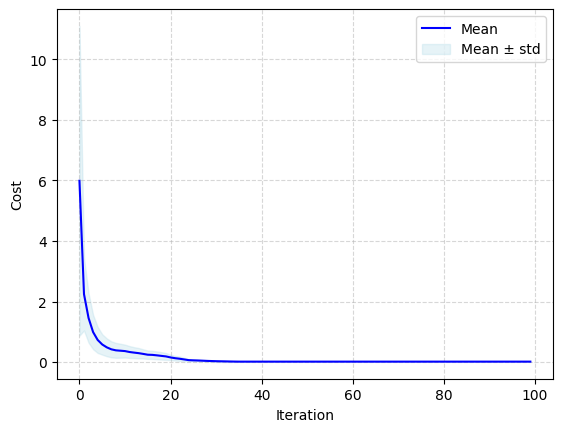

In [ ]:
# Plot only from iteration 20 to 80
plot_means_std(means, stds)


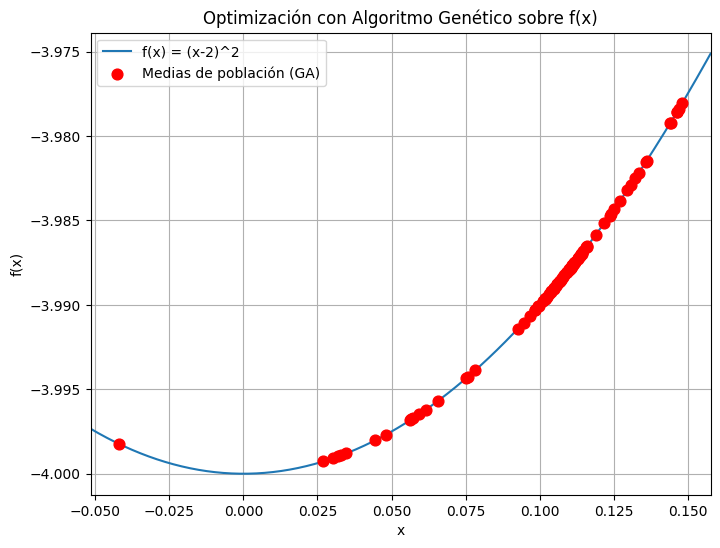

In [ ]:
#@title  **code** Medias de la poblacion en distintas iteraciones evaluadas en la funcion convexa escogida

import matplotlib.pyplot as plt
import numpy as npS

# Dominio para graficar la función
x_values = np.linspace(-9, 11, 300)
y_values = convex_function(x_values)

# Evaluamos la función en esos puntos
pop_means_y = convex_function(pop_means_np)

# Compute x-axis limits with 5% margin
x_min, x_max = np.min(pop_means_np), np.max(pop_means_np)
margin = 0.05 * (x_max - x_min)
x_lower, x_upper = x_min - margin, x_max + margin

# Domain restricted to this range
x_values = np.linspace(x_lower, x_upper, 300)
y_values = convex_function(x_values)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label='f(x) = (x-2)^2')
plt.scatter(pop_means_np, pop_means_y, color='red', s=60,
            label='Medias de población (GA)', zorder=5)
#plt.plot(pop_means_np, pop_means_y, color='red', linestyle='--', alpha=0.6)

plt.title('Optimización con Algoritmo Genético sobre f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend()

# Apply x limits
plt.xlim(x_lower, x_upper)

plt.show()

# Parte 2


La funcion de costo que planteamos solo contempla las funciones convexas cuyo minimo sea 0, si queremos hallar verdaderamente un minimo tenemos que remontarnos al calculo diferencial que usa el criterio de cuando $\dfrac{df}{dx}=0$.

Obviamente no queremos complicarnos programando algoritmos que hagan derivacion automatica, nuestro problema es unicamente hallar puntos donde la derivada sea 0 (o bueno, casi ).

Con este fin podemos en lugar de computar la derivada, evaluar la pendiente de la funcion en intervalos de $x$ muy pequeños:
$$\dfrac{df}{dx} \approx \frac{\Delta f}{\Delta x}$$

Donde $\Delta x = x_1 - x_0 \approx 0$ y $\Delta f = f(x_1) - (x_0)$

---
# **Ejercicio 5**  <a name="eje5"></a>
---

## **Segunda función de costo**

En algunos casos, no basta con evaluar si una función se acerca a cero: lo que realmente buscamos es encontrar el **mínimo** de la función.  
Para ello, podemos usar el criterio del cálculo diferencial: un punto es mínimo cuando  

$$\dfrac{df}{dx} = 0$$  

En lugar de implementar derivación simbólica, aproximaremos la derivada de forma numérica:  

$$\dfrac{df}{dx} \approx \frac{f(x + \Delta x) - f(x)}{\Delta x}$$  

con un valor pequeño de $\Delta x$.

### **Objetivo:**
Implementa la función `convex_cost2(solution, num_bits, min_val, max_val)`, tal que:

* Decodifique un individuo binario a un valor real $x$ dentro del rango `[min_val, max_val]`.  
* Evalúe la derivada discreta de $f(x) = x^{2} - 4$.  
* Devuelva el costo como el valor absoluto de la derivada, de modo que **valores cercanos a 0 indiquen mejores soluciones** (puntos críticos de la función).

### **Ejemplo:**

Si el individuo representa $x \approx 2$  

$f(x) = x^{2} - 4 = 0$,  
la derivada $f'(x) = 2x \approx 4$,  
y el costo será $|f'(2)| = 0$, lo que indica un mínimo.  

In [ ]:
def convex_cost2(solution, num_bits, min_val, max_val):
    import numpy as np

    # definir dentro la decodificación
    def gen_decimal_value(binary_array, num_bits, min_val, max_val):
        powers_of_2 = 2**np.arange(num_bits-1, -1, -1)
        int_val = np.dot(binary_array, powers_of_2)
        decimal_value = min_val + int_val * (max_val - min_val)/(2**num_bits - 1)
        return decimal_value

    # definir dentro la derivada discreta
    def get_discrete_derivative(f, x, dx=0.01):
        return (f(x + dx) - f(x)) / dx

    # definir dentro la función f(x)
    def convex_function(x):
        return x**2 - 4

    # decodificar x
    x = gen_decimal_value(solution, num_bits, min_val, max_val)
    # derivada discreta
    df_dx = get_discrete_derivative(convex_function, x)
    # costo = |derivada|
    cost = np.abs(df_dx)
    return cost

In [ ]:
#@title **check your answer**
import numpy as np

tests = []

# Caso 1: Evaluar en el mínimo esperado de f(x) = (x-2)^2
# + derivada debe ser ≈0, pero binario no exacto
s = np.array([0,1,0,0,0,0,0,0])  # algún binario que mapee cerca de x=2
c = convex_cost2(s, num_bits=8, min_val=0, max_val=10)
tests.append(("Cerca del mínimo (x≈2) → costo ~0", c < 1e-2))

# Caso 2: Evaluar un valor muy grande (x≈10)
s = np.ones(8)  # máximo binario
c = convex_cost2(s, num_bits=8, min_val=0, max_val=10)
tests.append(("x=10 → costo grande", c > 10))

# Caso 3: Reproducibilidad (misma entrada mismo valor)
s = np.array([1,0,1,1,0,1,1,0])
c1 = convex_cost2(s, 8, 0, 10)
c2 = convex_cost2(s, 8, 0, 10)
tests.append(("Determinístico", np.isclose(c1, c2)))

# Mostrar resultados
for name, ok in tests:
    print(f"{name}: {ok}")

Cerca del mínimo (x≈2) → costo ~0: False
x=10 → costo grande: True
Determinístico: True


### Salidas esperadas de la validación
```python
Cerca del mínimo (x≈2) → costo ~0: False
x=10 → costo grande: True
Determinístico: True

In [ ]:
#@title **send your answer**
student_func_str = inspect.getsource(convex_cost2)
r = check_solution_and_evaluate(assignment_id, student_func_str)

Score
	5.0
Message
	Excellent, you got the highest score.
Status
	You have achieved your best score: 5.0


---
# **Ejercicio 6**  <a name="eje6"></a>
---

## Segunda funcion de mutacion: Mutación binaria con probabilidad por gen

En los algoritmos genéticos que trabajan con **cromosomas binarios**, una estrategia de mutación muy utilizada consiste en **recorrer cada gen** y, con cierta probabilidad, **cambiar su valor** por la alternativa binaria. Es decir:

* Si el gen actual es `0`, pasa a `1`.
* Si el gen actual es `1`, pasa a `0`.

### Tu Tarea

Implemente la función **`convex_mutate2(solution, mutation_prob)`** que:

* Reciba como entrada un cromosoma binario `solution`
* Recorra cada posición del cromosoma.
* Con probabilidad `mutation_prob`, cambie el valor del gen por su **complemento binario** (0 → 1, 1 → 0).
* Devuelva la solución mutada como un nuevo arreglo.

### Ejemplo

Sea un cromosoma de longitud $5$:

$$
\text{solution} = [1,\;0,\;1,\;0,\;1]
$$

Con una probabilidad de mutación $\,p = 0.3$, cada gen tiene un 30% de probabilidad de invertirse:

$$
\text{mutated_solution} = [1,\;1,\;1,\;0,\;0]
$$

*(en este caso, los genes en las posiciones 1 y 4 fueron mutados).*

In [ ]:
def convex_mutate2(solution, mutation_prob):
    """
    Aplica mutación binaria con probabilidad mutation_prob a cada gen de solution.
    Cambia 0→1 y 1→0 con probabilidad mutation_prob.
    """
    import numpy as np   # <<--- añadido

    # Copiar para no modificar el original
    mutated = np.copy(solution)

    # Para cada índice del cromosoma
    for i in range(len(mutated)):
        if np.random.rand() < mutation_prob:
            mutated[i] = 1 - mutated[i]

    return mutated


In [ ]:
#@title **check your answer**

# Check para TSP_mutate2 versión 2.2
import numpy as np

tests = []

# Caso 1: mutation_prob=0 → no debe mutar nada
s = np.array([0,1,0,1,1,0])
m = convex_mutate2(s, mutation_prob=0)
tests.append(("mutation_prob=0 → debe ser igual a la entrada", np.array_equal(m, s)))

# Caso 2: mutation_prob=1 → todos los bits deben invertirse
s = np.array([0,0,1,1])
m = convex_mutate2(s, mutation_prob=1)
expected = 1 - s
tests.append(("mutation_prob=1 → todos los bits invertidos", np.array_equal(m, expected)))

# Caso 3: mutation_prob intermedio → debe seguir siendo binario y de la misma longitud
s = np.array([1,0,1,0,1,0])
m = convex_mutate2(s, mutation_prob=0.5)
tests.append(("mutation_prob=0.5 → sigue siendo binario", (len(m)==len(s)) and np.all(np.isin(m,[0,1]))))

# Mostrar resultados
for name, ok in tests:
    print(f"{name}: {ok}")


mutation_prob=0 → debe ser igual a la entrada: True
mutation_prob=1 → todos los bits invertidos: True
mutation_prob=0.5 → sigue siendo binario: True


### Salidas esperadas de la validación
```python
mutation_prob=0 → debe ser igual a la entrada: True
mutation_prob=1 → todos los bits invertidos: True
mutation_prob=0.5 → sigue siendo binario: True

In [ ]:
#@title **send your answer**
student_func_str = inspect.getsource(convex_mutate2)
r = check_solution_and_evaluate(assignment_id, student_func_str)

Score
	5.0
Message
	Excellent, you got the highest score.
Status
	You have achieved your best score: 5.0


In [ ]:
num_bits = 10
min_val = -10
max_val = 10

r =  run_ga(pop_size=1000,
               init_population_function = lambda x: convex_initialize_population(x, num_bits),
               mutation_function        = convex_mutate2,
               crossover_function       = convex_midpoint_crossover,
               cost_function            = lambda x: convex_cost2(x,num_bits, min_val, max_val),
               mean_pop_func            = lambda x: get_population_mean_from_binary(x,num_bits, min_val, max_val),
               crossover_prob           = 0.001,
               mutation_prob            = 0.1,
               n_iters                  = 100)

best, best_costs, means, stds, pop_means = r
pop_means_np = np.array(pop_means)

/tmp/ipython-input-4278027940.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_iters)):


  0%|          | 0/100 [00:00<?, ?it/s]

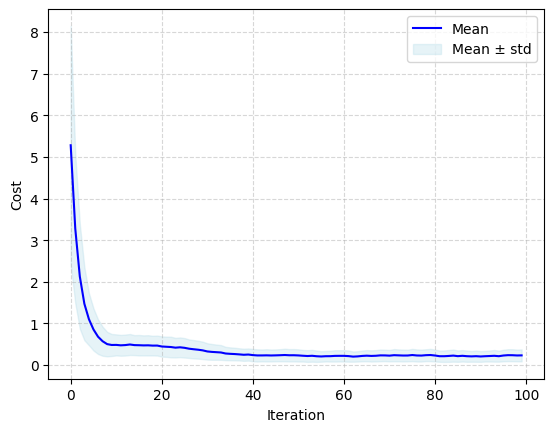

In [ ]:
# Plot only from iteration 20 to 80
plot_means_std(means, stds)


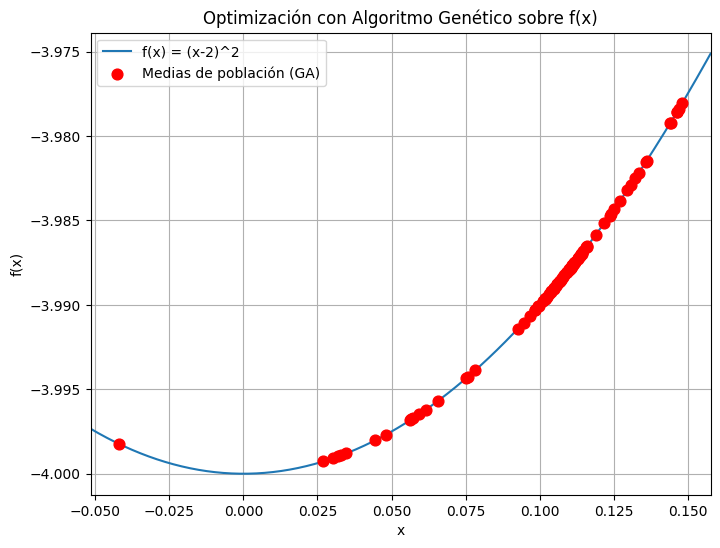

In [ ]:
#@title  **code** Medias de la poblacion en distintas iteraciones evaluadas en la funcion convexa escogida

import matplotlib.pyplot as plt
import numpy as npS

# Dominio para graficar la función
x_values = np.linspace(-9, 11, 300)
y_values = convex_function(x_values)

# Evaluamos la función en esos puntos
pop_means_y = convex_function(pop_means_np)

# Compute x-axis limits with 5% margin
x_min, x_max = np.min(pop_means_np), np.max(pop_means_np)
margin = 0.05 * (x_max - x_min)
x_lower, x_upper = x_min - margin, x_max + margin

# Domain restricted to this range
x_values = np.linspace(x_lower, x_upper, 300)
y_values = convex_function(x_values)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label='f(x) = (x-2)^2')
plt.scatter(pop_means_np, pop_means_y, color='red', s=60,
            label='Medias de población (GA)', zorder=5)
#plt.plot(pop_means_np, pop_means_y, color='red', linestyle='--', alpha=0.6)

plt.title('Optimización con Algoritmo Genético sobre f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend()

# Apply x limits
plt.xlim(x_lower, x_upper)

plt.show()

---
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/bannerThanks.jpg" alt="Drawing" style="width:700px;"/>